# MTA Subway Guide for Immunocompromised Transit Users
### The following notebook details the code run-down delineating traffic levels at different times/days for the NYC subway system. The goal is to provide ranked best travel times (lowest traffic times) by station/line to be used by immunocompromised transit riders to decide when is an opportune time to schedule travel through the city.

The following code:
1. Imports necessary packages    

In [125]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import urllib.request
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn import datasets

The following code 
1. Imports our data set with the complex ids that will be used to add complex_ids to our MTA turnstiles data set 
2. renames certain columns to match with our MTA turnstiles column names


In [126]:
complex_ids= pd.read_csv(r'/Users/mehikapatel/Downloads/remote_complex_lookupcsv/body.csv')
complex_ids.rename({'remote':'UNIT', 'division':'DIVISION','line_name':'LINENAME','booth':'C/A', "station": "STATION", "complex_id": "COMPLEX_ID"},inplace=True, axis=1)
complex_ids.head()

,UNIT,C/A,COMPLEX_ID,STATION,LINENAME,DIVISION
0,R001,A060,635.0,WHITEHALL ST,R1,BMT
1,R001,A058,635.0,WHITEHALL ST,R1,BMT
2,R001,R101S,635.0,SOUTH FERRY,R1,IRT
3,R002,A077,628.0,FULTON ST,ACJZ2345,BMT
4,R002,A081,628.0,FULTON ST,ACJZ2345,BMT


The following code:
1. Pulls our MTA turnstiles data from SQL to Python using SQLAlchemy into a datatable called df
2. Run a sample SQL query using SQLAlchemy to obtain 59 ST station's data
3. Gives us a look at some of the first entries in df

In [127]:
#pull data from SQL to python using SQLAlchemy
engine = create_engine("sqlite:///mta.db")
df = pd.read_sql('SELECT * FROM mta_data;', engine)


#SQLAlchemy Querying 59th ST for initial exploration
FIFTY_NINE_ST_DATA= pd.read_sql("select * FROM mta_data where station='59 ST'",engine)

df.head()
#describe the df
# df.describe()
#info on the df
# df.info()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,03:00:00,REGULAR,7508509,2557569
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,07:00:00,REGULAR,7508511,2557581
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,11:00:00,REGULAR,7508531,2557636
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,15:00:00,REGULAR,7508610,2557667
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,19:00:00,REGULAR,7508767,2557689


The following code:
1. Creates a datetime column in our df set called OBSERVED_TIME

In [128]:
#create a datetime column
df["OBSERVED_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,OBSERVED_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,03:00:00,REGULAR,7508509,2557569,2020-12-26 03:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,07:00:00,REGULAR,7508511,2557581,2020-12-26 07:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,11:00:00,REGULAR,7508531,2557636,2020-12-26 11:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,15:00:00,REGULAR,7508610,2557667,2020-12-26 15:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,19:00:00,REGULAR,7508767,2557689,2020-12-26 19:00:00


The following code:
1. Inserts an "ID" column for unique singular identification of a turnstile

In [129]:
ind_turnstile=df['C/A']+ ' '+df['UNIT']+ ' '+ df['SCP']

df.insert(0, 'ID', ind_turnstile)

df.head()

,ID,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,OBSERVED_TIME
0,A002 R051 02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,03:00:00,REGULAR,7508509,2557569,2020-12-26 03:00:00
1,A002 R051 02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,07:00:00,REGULAR,7508511,2557581,2020-12-26 07:00:00
2,A002 R051 02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,11:00:00,REGULAR,7508531,2557636,2020-12-26 11:00:00
3,A002 R051 02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,15:00:00,REGULAR,7508610,2557667,2020-12-26 15:00:00
4,A002 R051 02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,19:00:00,REGULAR,7508767,2557689,2020-12-26 19:00:00


The following code:
1. Drops Recovery Audit entries for cleaner dataset, after which there are 2365405 rows remaining in the dataframe

In [130]:
df.drop(df.loc[df['DESC']=='RECOVR AUD'].index, inplace=True)
#206295 ROWS AFTER DROPPING RECOVERY AUDITS
# df.info()

The following code:
1. Creates a new data frame that left merged the MTA turnstiles df with our complex ids data set, which ultimately adds the following variables to our MTA turnstiles:
    * complex_id
    * alternative station name found from complex id data set
    * drops alternative Station and Line Names
    * relabels STATION and LINENAME to original names

Our dataset still has 206295 rows.
 

In [131]:
#new df with complex ids added to MTA data
Pre_ADA_df=pd.merge(df,complex_ids, on=['UNIT','C/A','DIVISION'], how='left')
#still has 206295 entries
# Pre_ADA_df.info()

#drop new station and line name columns
Pre_ADA_df.drop(['STATION_y', 'LINENAME_y'], axis=1, inplace=True)

#rename columns back to station and linename
Pre_ADA_df.rename({'STATION_x':'STATION','LINENAME_x':'LINENAME'}, axis=1, inplace=True)
# Pre_ADA_df.info()
Pre_ADA_df.head()

,ID,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,OBSERVED_TIME,COMPLEX_ID
0,A002 R051 02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,03:00:00,REGULAR,7508509,2557569,2020-12-26 03:00:00,613.0
1,A002 R051 02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,07:00:00,REGULAR,7508511,2557581,2020-12-26 07:00:00,613.0
2,A002 R051 02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,11:00:00,REGULAR,7508531,2557636,2020-12-26 11:00:00,613.0
3,A002 R051 02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,15:00:00,REGULAR,7508610,2557667,2020-12-26 15:00:00,613.0
4,A002 R051 02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,19:00:00,REGULAR,7508767,2557689,2020-12-26 19:00:00,613.0


The following code:
1. Imports the ADA information dataset 
2. Renames Complex ID column to match our other dataframe

In [132]:
ADA=pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')
ADA.rename({'Complex ID': 'COMPLEX_ID', 'Division':'DIVISION'},inplace=True,axis=1)

### WHY ARE THERE SO MANY MORE ROWS EVEN WHEN I DID A LEFT JOIN?!
###### It was found that there was an increase in rows when merging ADA and MTA df so we are investigating in the following code. It seems the ADA dataset uses the same several (51) complex IDs multiple times, which leads to the merge creating a new row for every time a copmlex ID is used in the ADA df. We will sort this by investigating why complex IDs are used multiple times, and by sifting them down to a single complex id/or by combining the information provided.

In [133]:
ADA.COMPLEX_ID.nunique()
# ADA.info()

#445 unique values versus 496 entries in the dataframe = 51 times certain complex ids are being reused.

445

In [134]:
# ADA.COMPLEX_ID.describe()

We will drop/change certain values from our ADA set below according to later investigation underneath.

In [135]:
ADA.drop(162,axis=0, inplace=True)
ADA.drop(468,axis=0, inplace=True)
ADA.drop(469,axis=0, inplace=True)


ADA.drop(412,axis=0, inplace=True)
ADA.drop(171,axis=0, inplace=True)
ADA.drop(17,axis=0, inplace=True)
ADA.drop(103,axis=0, inplace=True)

ADA.drop(466,axis=0, inplace=True)
ADA.drop(470,axis=0, inplace=True)

ADA.drop(274,axis=0, inplace=True)
ADA.drop(116,axis=0, inplace=True)

ADA.drop(335,axis=0, inplace=True)

ADA.drop(91,axis=0, inplace=True)
ADA.drop(23,axis=0, inplace=True)
ADA.drop(26,axis=0, inplace=True)
ADA.drop(149,axis=0, inplace=True)

ADA.drop(166,axis=0, inplace=True)

ADA.drop(435,axis=0, inplace=True)
ADA.drop(111,axis=0, inplace=True)
ADA.drop(72,axis=0, inplace=True)


This finds us the complex IDs used multiple times:

In [136]:
# ADA.groupby(['COMPLEX_ID']).size().sort_values(ascending=False).head(10)

This creates a list of data frames with the complex ids found to be used multiple times.

In [137]:
dup_complexes=[611,628, 624,623,610,606,601,602,621,620,617,609,608,607,636,605,635,151,167,603,604,612,622,630,629,627,613,626,625,461,614, 618,615,616,619]


dup_complexes_rows=[]

for num in dup_complexes:
    dup_complexes_rows.append(ADA.loc[ADA['COMPLEX_ID'] == num])

In [138]:
# Pre_ADA_df.loc[Pre_ADA_df['COMPLEX_ID'] == 617]

In [139]:
# Pre_ADA_df.loc[Pre_ADA_df['COMPLEX_ID'] == 620].groupby(['STATION']).size()

In [140]:
Pre_ADA_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2365405 entries, 0 to 2365404
Data columns (total 14 columns):
 #   Column         Dtype         
---  ------         -----         
 0   ID             object        
 1   C/A            object        
 2   UNIT           object        
 3   SCP            object        
 4   STATION        object        
 5   LINENAME       object        
 6   DIVISION       object        
 7   DATE           object        
 8   TIME           object        
 9   DESC           object        
 10  ENTRIES        int64         
 11  EXITS          int64         
 12  OBSERVED_TIME  datetime64[ns]
 13  COMPLEX_ID     float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(10)
memory usage: 270.7+ MB


### Now that we have removed duplicated complex_id information by sifting throguh duplicates, we will also join on division to further nuance the data. Now we can see we have 2365405 entries as expected.

The following code:

1. Creates a final working dataset with several variables by combing MTA Data set with ADA dataset via complex ID

**Now our final dataset to work with and further clean will be ADA_df.**



In [141]:
ADA_df=pd.merge(Pre_ADA_df, ADA, how='left', on=['COMPLEX_ID', 'DIVISION'])

# ADA_df.info()

The following code:
1. Removes unecessary columns. 

In [142]:
ADA_df.drop(['DESC','Borough','Daytime Routes','Structure', 'Line','GTFS Stop ID'],axis=1,inplace=True)

In [143]:
# ADA_df.info()

The following code will:
1. Group the rows by turnstile and calculate the actual number of exits and entries.

In [144]:
ADA_df['ACTUALENTRIES']=ADA_df.groupby(['ID']).ENTRIES.diff()
ADA_df['ACTUALEXITS']=ADA_df.groupby(['ID']).EXITS.diff()

# ADA_df.info()

The following code will:
1. Begin the cleaning process by clearing out entries from hourset 1 of data collection (because these values will not be helpful to us as it is simply the cumulative number of entries and exits).
2. Will absolute value all actual exits and entries values to account for counters that may have counted backwards instead of up.
3. Remove any rows with actual entry and exit values larger than 10,000, as these will likely be entries where the counter reset and are not the actual numbers. 
4. Finally, remove the original Entries and Exits Columns and rename the actual entries and exits to ENTRIES & EXITS respectively.

In [145]:
#1.
ADA_df.dropna(axis=0,subset=['ACTUALENTRIES'],inplace=True)
ADA_df.dropna(axis=0,subset=['ACTUALEXITS'],inplace=True)
# ADA_df.info()

In [146]:
#2.
ADA_df.ACTUALENTRIES=ADA_df.ACTUALENTRIES.abs()
ADA_df.ACTUALEXITS=ADA_df.ACTUALEXITS.abs()
# ADA_df.ACTUALEXITS.describe()


In [147]:
#3.
ADA_df.drop(ADA_df[ADA_df.ACTUALENTRIES >1007].index, inplace=True)
ADA_df.drop(ADA_df[ADA_df.ACTUALEXITS >2225].index, inplace=True)

The following comments show code used to sort through high values to check for counter reset to set above drop value conditionals.

In [148]:
# ADA_df_TESTER=ADA_df.copy()

# ADA_df_TESTER.drop(ADA_df_TESTER[ADA_df_TESTER.ACTUALENTRIES >1007].index, inplace=True)
# ADA_df_TESTER.drop(ADA_df_TESTER[ADA_df_TESTER.ACTUALEXITS >2225].index, inplace=True)
# ADA_df_TESTER.ACTUALEXITS.describe()
# # ADA_df_TESTER.info()
# # df.drop(df[df.score < 50].index, inplace=True)

In [149]:
#4. 
ADA_df.drop(['ENTRIES'],axis=1,inplace=True)
ADA_df.drop(['EXITS'],axis=1,inplace=True)

In [150]:
ADA_df.rename({"ACTUALENTRIES":'ENTRIES',"ACTUALEXITS":"EXITS"},axis=1, inplace=True)
# ADA_df.info()

## Now analysis and plotting

The following code:
1. Creates a new column called "ACTIVITY" that is a sum of entries and exits as a metric for general traffic over time period in that area. 
2. Runs an initial analysis on 59 ST station activity data for week one.  (This will result in guidelines for what time is best to travel through this station.
3. Plots the data points for 59 ST Data.


In [151]:
#1.
ADA_df['ACTIVITY']= ADA_df.ENTRIES + ADA_df.EXITS

In [152]:
#create a df for just 59 ST station data
station_59_st= ADA_df[ADA_df['STATION']=='59 ST']
# station_59_st=station_59_st[station_59_st['DATE']=='03/15/2021']
# station_59_st.info()

In [153]:
#2. 
station_59_st[['ENTRIES','EXITS','ACTIVITY']].describe().round()

,ENTRIES,EXITS,ACTIVITY
count,26602.0,26602.0,26602.0
mean,51.0,58.0,109.0
std,73.0,82.0,121.0
min,0.0,0.0,0.0
25%,4.0,8.0,18.0
50%,23.0,28.0,68.0
75%,68.0,76.0,159.0
max,837.0,1061.0,1634.0


As we can see from the above analysis on numbers, the average number of transit riders on in a four hour period in the 59 ST Station is 121. Now we will see what the lowest activity traffic hours are for this station by grouping by time.


In [154]:
station_59_st.groupby(station_59_st.OBSERVED_TIME.dt.hour).mean().round().sort_values(by='ACTIVITY')

,COMPLEX_ID,Station ID,GTFS Latitude,GTFS Longitude,ADA,ENTRIES,EXITS,ACTIVITY
OBSERVED_TIME,,,,,,,,
4,479.0,239.0,41.0,-74.0,0.0,4.0,6.0,10.0
3,480.0,228.0,41.0,-74.0,0.0,10.0,11.0,20.0
6,613.0,400.0,41.0,-74.0,0.0,1.0,37.0,39.0
7,481.0,230.0,41.0,-74.0,0.0,14.0,26.0,41.0
0,476.0,240.0,41.0,-74.0,0.0,32.0,26.0,58.0
9,613.0,400.0,41.0,-74.0,0.0,10.0,55.0,65.0
23,482.0,229.0,41.0,-74.0,0.0,42.0,31.0,73.0
8,489.0,238.0,41.0,-74.0,0.0,33.0,67.0,100.0
18,613.0,400.0,41.0,-74.0,0.0,58.0,49.0,107.0


The above lists in order the lowest traffic four hour period (starting time indicated by hour number under OBSERVED_TIME column) to the highest traffic periods. A client may observe such indicators by station to plan how they might travel depending on traffic levels through the day. 

In [155]:
means_59_st=station_59_st.groupby(station_59_st.OBSERVED_TIME.dt.hour).mean().round().reset_index()

In [156]:
means_59_st.sort_values(by='ACTIVITY')

# plt.savefig("59_ST_Chart.png")

,OBSERVED_TIME,COMPLEX_ID,Station ID,GTFS Latitude,GTFS Longitude,ADA,ENTRIES,EXITS,ACTIVITY
2,4,479.0,239.0,41.0,-74.0,0.0,4.0,6.0,10.0
1,3,480.0,228.0,41.0,-74.0,0.0,10.0,11.0,20.0
3,6,613.0,400.0,41.0,-74.0,0.0,1.0,37.0,39.0
4,7,481.0,230.0,41.0,-74.0,0.0,14.0,26.0,41.0
0,0,476.0,240.0,41.0,-74.0,0.0,32.0,26.0,58.0
6,9,613.0,400.0,41.0,-74.0,0.0,10.0,55.0,65.0
14,23,482.0,229.0,41.0,-74.0,0.0,42.0,31.0,73.0
5,8,489.0,238.0,41.0,-74.0,0.0,33.0,67.0,100.0
11,18,613.0,400.0,41.0,-74.0,0.0,58.0,49.0,107.0
9,15,481.0,229.0,41.0,-74.0,0.0,62.0,75.0,137.0


[Text(0.5, 1.0, '59 St Activity By the Hour'),
 Text(0.5, 0, 'Hour of Day'),
 Text(0, 0.5, 'Activity')]

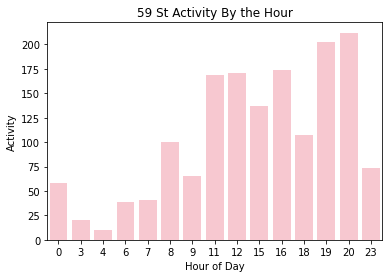

In [157]:
sns.barplot(x = means_59_st.OBSERVED_TIME,
            y=means_59_st.ACTIVITY, 
            color="pink").set(title="59 St Activity By the Hour", xlabel="Hour of Day", ylabel="Activity")

# plt.savefig("59_ST.png")

# Plotting Heatmaps

The following code will:
1. Find the ten most popular stations.
2. Create a data frame with these stations.
3. Create individual data frames for each station for easier/clearer syntax in plotting.
4. Plot heatmaps for those stations (one large one for all of them and individual ones for each).


In [158]:
#1.Find 10 most popular stations

# ADA_df.groupby(['STATION']).ACTIVITY.sum().sort_values(ascending=False).head(10)

The following stations had the most traffic overall over the three month period:
1. 34 ST-PENN STA 
2. 34 ST-HERALD SQ
3. 86 ST 
4. 125 ST
5. 42 ST-PORT AUTH 
6. 14 ST-UNION SQ
7. GRD CNTRL-42 ST
8. 23 ST 
9. 59 ST
10. FLUSHING-MAIN


In [159]:
#2 Create a data frame with these stations
station_34_st_penn=ADA_df[ADA_df['STATION']=='34 ST-PENN STA']
station_34_st_herald=ADA_df[ADA_df['STATION']=='34 ST-HERALD SQ']
station_86_st=ADA_df[ADA_df['STATION']=='86 ST']
station_125_st=ADA_df[ADA_df['STATION']=='125 ST']
station_42_st=ADA_df[ADA_df['STATION']=='42 ST-PORT AUTH']
station_14_st=ADA_df[ADA_df['STATION']=='14 ST-UNION SQ']
station_grd_cntrl=ADA_df[ADA_df['STATION']=='GRD CNTRL-42 ST']
station_23_st=ADA_df[ADA_df['STATION']=='23 ST']
station_59_st=ADA_df[ADA_df['STATION']=='59 ST']
station_flushing=ADA_df[ADA_df['STATION']=='FLUSHING-MAIN']

top10=pd.concat([station_34_st_penn,station_34_st_herald,station_86_st,station_125_st,station_42_st,station_14_st,station_grd_cntrl,station_23_st,station_59_st,station_flushing])
# top10.info()

In [160]:
piv_top10=pd.pivot_table(data=top10,index=top10.OBSERVED_TIME.dt.hour, columns=top10.OBSERVED_TIME.dt.day_name(), values=['ACTIVITY'])

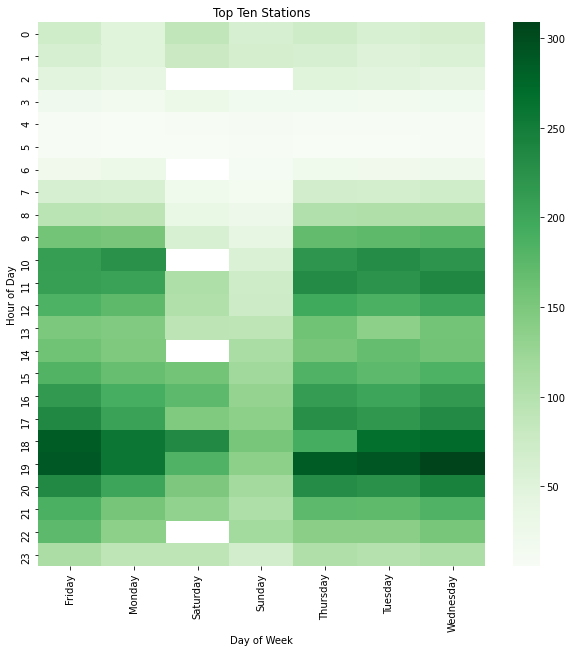

In [191]:
plt.figure(figsize = [10,10])
y_labels=[0,3,4,6,7,8,9,11,12,15,16,18,19,20,23]
x_labels= ["Friday", "Monday", "Saturday", "Sunday", "Thursday", "Tuesday","Wednesday"]
sns.heatmap(piv_top10,cmap='Greens').set(title="Top Ten Stations", xlabel="Day of Week",ylabel="Hour of Day",xticklabels=x_labels)


plt.savefig("Top Ten Stations Heatmap.png")

The following code:
1. Creates a data set with only fully ADA accessible stations.
2. Finds ten most popular stations from this list.
3. Creates heatmaps for each of these tables (one for all, and one for each individually).

In [163]:
#1
ADA_only=ADA_df[ADA_df['ADA']>0]

In [164]:
# ADA_only.groupby(['STATION']).ACTIVITY.sum().sort_values(ascending=False).head(10)

The following stations had the most traffic overall over the three month period:
1. 34 ST-PENN STA 
2. 34 ST-HERALD SQ
3. GRD CNTRL-42 ST
4. 125 ST 
5. FLUSHING-MAIN
6. 86 ST 
7. TIMES SQ-42 ST
8. JKSN HT-ROOSVLT
9. 59 ST COLUMBUS
10. 14 ST-UNION SQ



In [165]:
# station_34_st_penn=ADA_df[ADA_df['STATION']=='34 ST-PENN STA']
# station_34_st_herald=ADA_df[ADA_df['STATION']=='34 ST-HERALD SQ']
# station_86_st=ADA_df[ADA_df['STATION']=='86 ST']
# station_125_st=ADA_df[ADA_df['STATION']=='125 ST']
station_times_42_st=ADA_df[ADA_df['STATION']=='TIMES SQ-42 ST']
# station_14_st=ADA_df[ADA_df['STATION']=='14 ST-UNION SQ']
# station_grd_cntrl=ADA_df[ADA_df['STATION']=='GRD CNTRL-42 ST']
station_jksn=ADA_df[ADA_df['STATION']=='JKSN HT-ROOSVLT']
station_59_st_columbus=ADA_df[ADA_df['STATION']=='59 ST COLUMBUS']
# station_flushing=ADA_df[ADA_df['STATION']=='FLUSHING-MAIN']

top10_ada=pd.concat([station_34_st_penn,station_34_st_herald,station_86_st,station_125_st,station_times_42_st,station_14_st,station_grd_cntrl,station_jksn,station_59_st_columbus,station_flushing])


In [166]:
# pivot table of top ten ADA
piv_top10_ADA=pd.pivot_table(data=top10_ada,index=top10_ada.OBSERVED_TIME.dt.hour, columns=top10_ada.OBSERVED_TIME.dt.day_name(), values=['ACTIVITY'])

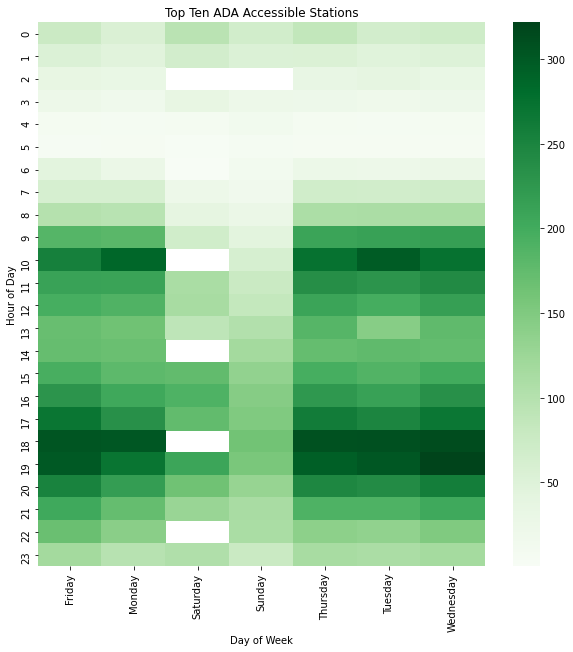

In [194]:
plt.figure(figsize = [10,10])
y_labels=[0,3,4,6,7,8,9,11,12,15,16,18,19,20,23]
x_labels= ["Friday", "Monday", "Saturday", "Sunday", "Thursday", "Tuesday","Wednesday"]
sns.heatmap(piv_top10_ADA,cmap='Greens').set(title="Top Ten ADA Accessible Stations", xlabel="Day of Week",ylabel="Hour of Day",xticklabels=x_labels)

plt.savefig("Top Ten ADA Stations Heatmap.png")

Now for attempting to map!

In [168]:
df_means=ADA_df.groupby(['STATION', 'DIVISION']).mean()

In [169]:
# Week1_data.head(10)

In [170]:
from bokeh.models import *
from bokeh.plotting import *
from bokeh.io import *
from bokeh.tile_providers import *
from bokeh.palettes import *
from bokeh.transform import *
from bokeh.layouts import *

In [190]:
def lon_lat_to_web_mercator(df, lon, lat):
    """Converts decimal longitude/latitude to Web Mercator format"""
    
    k = 6378137
    df["x"] = df[lon] * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    
    return df

mapping_df=lon_lat_to_web_mercator(df_means,'GTFS Longitude','GTFS Latitude')

In [187]:
#scale

scale=2000
x=mapping_df['x']
y=mapping_df['y']

#automatic ranging around points

x_min=int(x.mean() - (scale * 350))
x_max=int(x.mean() + (scale * 350))
y_min=int(y.mean() - (scale * 350))
y_max=int(y.mean() + (scale * 350))

#map tile as OSM

tile_provider=get_provider(OSM)

#bokeh plot and underlay

plot=figure(
    title='NYC Subway System',
    match_aspect=True,
    tools='wheel_zoom,pan,reset,save',
    x_range=(x_min, x_max),
    y_range=(y_min, y_max),
    x_axis_type='mercator',
    y_axis_type='mercator'
    )

plot.grid.visible=True

map=plot.add_tile(tile_provider)
map.level='underlay'

plot.xaxis.visible = False
plot.yaxis.visible=False

output_notebook()



Loading BokehJS ...

In [188]:
def bubble_map(plot,df,rad,lon,lat,scale,color='green',leg_label='Bubble Map'):
  radius=[]
  for i in df[radius_col]:
    radius.append(i*scale)
  
  df['radius']=radius
    
  source=ColumnDataSource(df)
  c=plot.circle(x='x',y='y',color=color,source=source,size=1,fill_alpha=0.4,radius='radius',legend_label=leg_label,hover_color='red')

  tip_label='@'+rad

  circle_hover = HoverTool(tooltips=[(rad,tip_label)],mode='mouse',point_policy='follow_mouse',renderers=[c])
  circle_hover.renderers.append(c)
  plot.tools.append(circle_hover)

  plot.legend.location = "top_right"
  plot.legend.click_policy="hide"

In [193]:
#bubble map
bubble_map(plot=plot,
           df=df_means,
           radius_col='ACTIVITY', 
           leg_label='NYC Subway System',
           lon='GTFS Longitude',
           lat='GTFS Longitude',
           scale=1)

show(plot)

<Figure size 432x288 with 0 Axes>

In [185]:
df_by_days=ADA_df.groupby(['STATION', 'DIVISION',ADA_df.OBSERVED_TIME.dt.dayofweek]).mean()
df_by_days.reset_index(inplace=True)


monday=df_by_days[df_by_days['OBSERVED_TIME']==0]
tuesday=df_by_days[df_by_days['OBSERVED_TIME']==1]
wednesday=df_by_days[df_by_days['OBSERVED_TIME']==2]
thursday=df_by_days[df_by_days['OBSERVED_TIME']==3]
friday=df_by_days[df_by_days['OBSERVED_TIME']==4]
saturday=df_by_days[df_by_days['OBSERVED_TIME']==5]
sunday=df_by_days[df_by_days['OBSERVED_TIME']==6]
# monday

In [186]:
# #monday map
# bubble_map(plot=plot,
#            df=monday,
#            radius_col='ACTIVITY', 
#            leg_label='NYC Subway System',
#            lon='GTFS Longitude',
#            lat='GTFS Longitude',
#            scale=1)

# # let's see our handiwork!
# show(plot)

<ipython-input-174-43abfba3267c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['radius']=radius
ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : key "x" value "x", key "y" value "y" [renderer: GlyphRenderer(id='3877', ...)]
ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : key "x" value "x", key "y" value "y" [renderer: GlyphRenderer(id='4159', ...)]
ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name.

In [178]:
# #tuesday map
# bubble_map(plot=plot,
#            df=tuesday,
#            radius_col='ACTIVITY', 
#            leg_label='NYC Subway System',
#            lon='GTFS Longitude',
#            lat='GTFS Longitude',
#            scale=1)

<ipython-input-174-43abfba3267c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['radius']=radius


In [179]:
# #wednesday map
# bubble_map(plot=plot,
#            df=wednesday,
#            radius_col='ACTIVITY', 
#            leg_label='NYC Subway System',
#            lon='GTFS Longitude',
#            lat='GTFS Longitude',
#            scale=1)

<ipython-input-174-43abfba3267c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['radius']=radius


In [180]:
# #thursday map
# bubble_map(plot=plot,
#            df=thursday,
#            radius_col='ACTIVITY', 
#            leg_label='NYC Subway System',
#            lon='GTFS Longitude',
#            lat='GTFS Longitude',
#            scale=1)

<ipython-input-174-43abfba3267c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['radius']=radius


In [181]:
# #friday map
# bubble_map(plot=plot,
#            df=friday,
#            radius_col='ACTIVITY', 
#            leg_label='NYC Subway System',
#            lon='GTFS Longitude',
#            lat='GTFS Longitude',
#            scale=1)

<ipython-input-174-43abfba3267c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['radius']=radius


In [182]:
# #saturday map
# bubble_map(plot=plot,
#            df=saturday,
#            radius_col='ACTIVITY', 
#            leg_label='NYC Subway System',
#            lon='GTFS Longitude',
#            lat='GTFS Longitude',
#            scale=1)

<ipython-input-174-43abfba3267c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['radius']=radius


In [183]:
# #sunday map
# bubble_map(plot=plot,
#            df=sunday,
#            radius_col='ACTIVITY', 
#            leg_label='NYC Subway System',
#            lon='GTFS Longitude',
#            lat='GTFS Longitude',
#            scale=1)

<ipython-input-174-43abfba3267c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['radius']=radius
